In [1]:
from diffusers import DiffusionPipeline
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tqdm

In [3]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version according to PyTorch:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("GPU name (if any):", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print(torch.version.cuda)

Torch version: 2.9.1+cu128
CUDA available: True
CUDA version according to PyTorch: 12.8
cuDNN version: 91002
GPU name (if any): NVIDIA GeForce GTX 1660 Ti
12.8


### Dinge die wir lernten:

- ist witzig, lol
- quali von pretrained cats ist mies
- gelernt wie die internen predictions gemacht werden (haben in scheduling_ddpm reingeguckt)
- die internen x_0 predictions von dem Model sind nicht so wie erwartet
    - ich habe erwartet, dass die die predictions sehr blobby sein werden, aber nicht so noisy trotzdem
- vielleicht sieht es ja bei anderen Modellen besser aus, vorallem solche, die mehrere verschiedene Objecte generieren können

- DDIM macht schon eher das in Richtung Blob, ist dafür aber seeehr schlecht von der Bildquali


### Dinge die wir noch tun wollen:

- anschauen wie andere noise einfluss auf den Bildprocess hat
- einen noise Seed festsetzen und mehrere Bilder darauf generieren und gucken ob es da zusammenhlänge gibt
- von einem halben denoised Bild als Seed weiterarbeiteen und gucken was das modell da macht
- andere scheduler nutzen

- mixed bilder generieren, indem wir zwei pipelines abwechselnd nutzen 

In [4]:
def save_img(img, path="results"):
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    img.save(f"{path}/{timestamp}.png")

In [5]:
generator = DiffusionPipeline.from_pretrained("anton-l/ddpm-butterflies-128").to("cuda")


Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 12.01it/s]


100%|██████████| 1000/1000 [00:41<00:00, 24.12it/s]


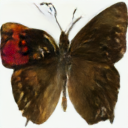

In [6]:
image = generator().images[0]
image

In [8]:
from diffusers import DDPMPipeline


In [9]:
ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 14.43it/s]


100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


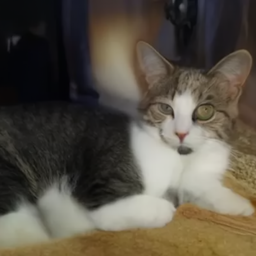

In [10]:
image = ddpm(num_inference_steps=100).images[0]
save_img(image)
image

In [11]:
from diffusers import DDPMScheduler, UNet2DModel, DDIMScheduler

In [12]:
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
scheduler = DDIMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [13]:
scheduler.set_timesteps(50)
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [15]:
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

In [16]:
input = noise

for t in scheduler.timesteps:

    with torch.no_grad():

        noisy_residual = model(input, t).sample

    input = input - 0.03 * noisy_residual

In [17]:
residuals = []
predictions = []
noises = []
funnys = []

x0_predictions = []
scheduler_code_pred = []
input = noise
pred_original_sample = noise
alphas_cumprod = scheduler.alphas_cumprod.to("cuda")

for t in tqdm.tqdm(scheduler.timesteps):
    # index = (scheduler.timesteps == t).nonzero().item()
    alpha_bar = alphas_cumprod[t]
    #print(alpha_bar)
    sqrt_alpha_bar = torch.sqrt(alpha_bar)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)
    noises.append(input)

    with torch.no_grad():

        # noisy_residual = model(pred_original_sample, t).sample
        noisy_residual = model(input, t).sample

    # funny = scheduler.step(noisy_residual,20, input).prev_sample

    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample

    input = previous_noisy_sample

    x0_pred = (input - (sqrt_one_minus_alpha_bar * noisy_residual)) / sqrt_alpha_bar

    alpha_prod_t = alpha_bar
    beta_prod_t = 1 - alpha_prod_t
    pred_original_sample = (input - beta_prod_t ** (0.5) * noisy_residual) / alpha_prod_t ** (0.5)

    x0_predictions.append(x0_pred)
    scheduler_code_pred.append(pred_original_sample)
    # funnys.append(funny)
    residuals.append(noisy_residual)
    predictions.append(previous_noisy_sample)


100%|██████████| 50/50 [00:06<00:00,  8.13it/s]


Predictions wie das originalbild aussehen könnte, also von jeden zeitschritt t aus das Original bestimmen

In [ ]:
images = []
for i in range(0,len(noises),1):
    image = ((x0_predictions[i]) / 2 + 0.5).clamp(0, 1).squeeze()

    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()

    images.append(image)
    image = Image.fromarray(image)

    image.save(f"anim5/{i}.png")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Beispiel: Zufällige Bilder generieren
# images = np.random.randint(0, 255, (10, 64, 64, 3), dtype=np.uint8)

def show_image(index, images):
    plt.figure(figsize=(5,5))
    # Prüfen, ob Bild RGB oder Graustufen
    if images.ndim == 4:
        plt.imshow(images[index])
    else:
        plt.imshow(images[index], cmap='gray')
    plt.axis('off')
    plt.show()

# Slider erstellen
slider = widgets.IntSlider(min=0, max=len(images)-1, step=1, description='Image')
widgets.interact(show_image, index=slider, images=images )



speichert die predictions von t50-> t49

In [21]:
for i in range(0,len(scheduler.timesteps),1):
    image = ((predictions[i]) / 2 + 0.5).clamp(0, 1).squeeze()

    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()

    image = Image.fromarray(image)

    image.save(f"anim5_1/{i}.png")

0


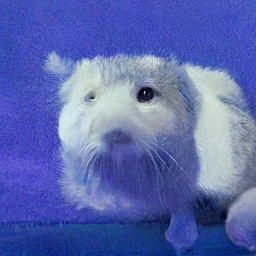

In [20]:
image = ((input) / 2 + 0.5).clamp(0, 1).squeeze()

image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()

print(image.min())      

image = Image.fromarray(image)

save_img(image)
image

In [16]:
my_residuals = []

for i in range(len(noises)):
    my_residuals.append(noises[i] - 1 * residuals[i])

In [21]:
print(scheduler.config)

FrozenDict([('num_train_timesteps', 1000), ('beta_start', 0.0001), ('beta_end', 0.02), ('beta_schedule', 'linear'), ('trained_betas', None), ('variance_type', 'fixed_small'), ('clip_sample', True), ('prediction_type', 'epsilon'), ('thresholding', False), ('dynamic_thresholding_ratio', 0.995), ('clip_sample_range', 1.0), ('sample_max_value', 1.0), ('timestep_spacing', 'leading'), ('steps_offset', 0), ('rescale_betas_zero_snr', False), ('_use_default_values', ['steps_offset', 'sample_max_value', 'clip_sample_range', 'prediction_type', 'timestep_spacing', 'dynamic_thresholding_ratio', 'thresholding', 'rescale_betas_zero_snr']), ('_class_name', 'DDPMScheduler'), ('_diffusers_version', '0.1.1')])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.597089..4.5074396].


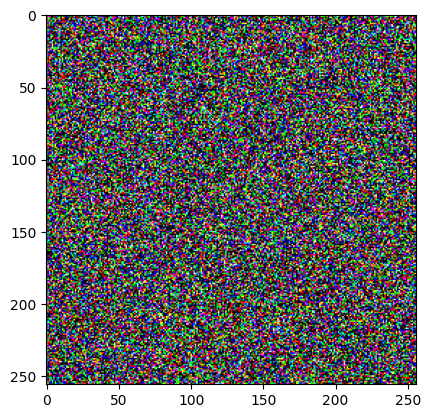

In [22]:
sub = noise[0]
plt.imshow(sub.permute(1,2,0).cpu())